<a href="https://colab.research.google.com/github/hasiburrahman1/NLP/blob/master/factroid_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
import tensorflow as tf 
import tensorflow_addons as tfa
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dropout, Input, Conv2D, MaxPool2D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.optimizers import Adam
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input, GlobalMaxPooling1D

####Convert XML into DataFrame


In [37]:
xtree = et.parse("/content/drive/My Drive/Colab Notebooks/MedQuAD_3_GHR_QA/joined.xml")
xroot = xtree.getroot()
lst = xroot.findall('QAPairs/QAPair')
data1 = []
data2 = []
data3 = []
print(len(lst))
#print(lst)
print("\n")

for item in lst:
    for x in item:
         if x.get('qtype') != None:
            qtype = x.get('qtype')
            data1.append(qtype)
    Question = item.find('Question').text
    data2.append(Question)
    Answer = item.find('Answer').text
    data3.append(Answer)

5430




In [38]:
df = pd.DataFrame(list(zip(data1, data2, data3)), 
               columns =['qtype', 'Question', 'Answer']) 

df.drop(df.columns[[2]], axis = 1, inplace = True)
print(len(df)) 
df

5430


,qtype,Question
0,information,What is (are) Aarskog-Scott syndrome ?
1,frequency,How many people are affected by Aarskog-Scott ...
2,genetic changes,What are the genetic changes related to Aarsko...
3,inheritance,Is Aarskog-Scott syndrome inherited ?
4,treatment,What are the treatments for Aarskog-Scott synd...
...,...,...
5425,information,What is (are) 9q22.3 microdeletion ?
5426,frequency,How many people are affected by 9q22.3 microde...
5427,genetic changes,What are the genetic changes related to 9q22.3...
5428,inheritance,Is 9q22.3 microdeletion inherited ?


###Basic data cleaning

In [39]:
df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [40]:
df["qtype"].value_counts()

information        1086
genetic changes    1086
treatment          1086
frequency          1086
inheritance        1086
Name: qtype, dtype: int64

In [41]:
## categorical to numerical
encode = {
    "genetic changes" : 0,
    "inheritance"  : 1,       
    "frequency" : 2,    
    "information" : 3,     
    "treatment"  : 4,    
}

In [42]:
df["qtype"] = df["qtype"].apply(lambda x: encode[x])
df.head()

,qtype,Question
0,3,What is (are) Aarskog-Scott syndrome ?
1,2,How many people are affected by Aarskog-Scott ...
2,0,What are the genetic changes related to Aarsko...
3,1,Is Aarskog-Scott syndrome inherited ?
4,4,What are the treatments for Aarskog-Scott synd...


###Data cleaning for NLP

In [43]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [45]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    ques_lines = list()
    lines = df["Question"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        
        ques_lines.append(words)
        
    return ques_lines

ques_lines = CleanTokenize(df)
print("total line are ", len(ques_lines)) 
ques_lines[0:10]

total line are  5430


[['aarskogscott', 'syndrome'],
 ['many', 'people', 'affected', 'aarskogscott', 'syndrome'],
 ['genetic', 'changes', 'related', 'aarskogscott', 'syndrome'],
 ['aarskogscott', 'syndrome', 'inherited'],
 ['treatments', 'aarskogscott', 'syndrome'],
 ['abdominal', 'wall', 'defect'],
 ['many', 'people', 'affected', 'abdominal', 'wall', 'defect'],
 ['genetic', 'changes', 'related', 'abdominal', 'wall', 'defect'],
 ['abdominal', 'wall', 'defect', 'inherited'],
 ['treatments', 'abdominal', 'wall', 'defect']]

In [46]:
len(max(ques_lines, key=len))

13

###Train-test split

In [47]:
validation_split = 0.2
max_length = 15


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(ques_lines)
sequences = tokenizer_obj.texts_to_sequences(ques_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

ques_lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
qtype =  df['qtype'].values

indices = np.arange(ques_lines_pad.shape[0])
np.random.shuffle(indices)
ques_lines_pad = ques_lines_pad[indices]
qtype = qtype[indices]

n_values = np.max(qtype) + 1

Y = np.eye(n_values)[qtype]


num_validation_samples = int(validation_split * ques_lines_pad.shape[0])

X_train_pad = ques_lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test_pad = ques_lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

unique tokens -  1419
vocab size - 1420


In [48]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (4344, 15)
Shape of y_train: (4344, 5)
Shape of X_test_pad: (1086, 15)
Shape of y_test: (1086, 5)


###Custom word2vec model

In [49]:
import gensim
model = gensim.models.Word2Vec(sentences=ques_lines, size=100, window=5, workers=4, min_count=1, sg=1) #sg= 1:skip-gram 0:cbow
vocab_words = list(model.wv.vocab)   

print(len(vocab_words))
print(vocab_words)

1419
['aarskogscott', 'syndrome', 'many', 'people', 'affected', 'genetic', 'changes', 'related', 'inherited', 'treatments', 'abdominal', 'wall', 'defect', 'abetalipoproteinemia', 'acatalasemia', 'aceruloplasminemia', 'achondrogenesis', 'achondroplasia', 'achromatopsia', 'acral', 'peeling', 'skin', 'acromicric', 'dysplasia', 'actinaccumulation', 'myopathy', 'activated', 'acute', 'promyelocytic', 'leukemia', 'adamsoliver', 'dyskinesia', 'adenine', 'phosphoribosyltransferase', 'deficiency', 'adenosine', 'deaminase', 'monophosphate', 'adenylosuccinate', 'lyase', 'adermatoglyphia', 'adiposis', 'dolorosa', 'adolescent', 'idiopathic', 'scoliosis', 'adult', 'polyglucosan', 'body', 'disease', 'adultonset', 'leukoencephalopathy', 'axonal', 'spheroids', 'pigmented', 'glia', 'african', 'iron', 'overload', 'agerelated', 'macular', 'degeneration', 'aicardi', 'aicardigoutieres', 'alagille', 'alexander', 'disorder', 'glycosylation', 'alkaptonuria', 'allanherndondudley', 'allergic', 'asthma', 'alpershu

In [50]:
filename = "questype_word2vec_full.txt"
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [51]:
embedding_index = {}
f = open(os.path.join('', '/content/questype_word2vec_full.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [52]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [53]:
embedding_matrix.shape

(1420, 100)

In [54]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

##Create LSTM model

In [55]:
# https://rdrr.io/cran/tfaddons/man/metrics_f1score.html
# https://github.com/tensorflow/addons/issues/825
model1 = Sequential()
model1.add(embedding_layer)
# Recurrent layer
model1.add(LSTM(100, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model1.add(Dense(100, activation='relu'))

# Dropout for regularization
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(5, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.FBetaScore(num_classes=5, average="macro", threshold=0.5 )])

print(model1.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 233,005
Trainable params: 91,005
Non-trainable params: 142,000
_________________________________________________________________
None



###LSTM Model Training

In [56]:
history = model1.fit(X_train_pad, y_train, epochs=10,batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/10
136/136 [==============================] - 9s 65ms/step - loss: 1.0795 - accuracy: 0.5424 - precision_5: 0.7961 - recall_5: 0.3407 - fbeta_score: 0.4456 - val_loss: 0.6004 - val_accuracy: 0.7017 - val_precision_5: 0.8000 - val_recall_5: 0.6703 - val_fbeta_score: 0.6723
Epoch 2/10
136/136 [==============================] - 8s 60ms/step - loss: 0.4655 - accuracy: 0.8135 - precision_5: 0.8637 - recall_5: 0.7555 - fbeta_score: 0.7927 - val_loss: 0.5136 - val_accuracy: 0.8260 - val_precision_5: 0.8362 - val_recall_5: 0.8177 - val_fbeta_score: 0.8265
Epoch 3/10
136/136 [==============================] - 8s 61ms/step - loss: 0.3376 - accuracy: 0.8669 - precision_5: 0.8867 - recall_5: 0.8432 - fbeta_score: 0.8596 - val_loss: 0.2449 - val_accuracy: 0.8941 - val_precision_5: 0.9052 - val_recall_5: 0.8877 - val_fbeta_score: 0.8950
Epoch 4/10
136/136 [==============================] - 8s 60ms/step - loss: 0.2958 - accuracy: 0.8854 - precision_5: 0.8978 - recall_5: 0.8736 - fbeta_score: 

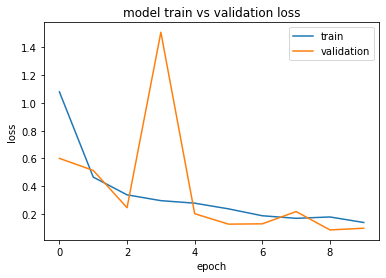

In [57]:

from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()


####Bidirectional LSTM

In [58]:

model2 =Sequential()
model2.add(embedding_layer)

model2.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.25)))
model2.add(Dense(5, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.FBetaScore(num_classes=5, average="macro", threshold=0.5)])

print(model2.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1005      
Total params: 303,805
Trainable params: 161,805
Non-trainable params: 142,000
_________________________________________________________________
None


In [59]:
history = model2.fit(X_train_pad, y_train, epochs=10,batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/10
136/136 [==============================] - 16s 116ms/step - loss: 0.9187 - accuracy: 0.6849 - precision_6: 0.8910 - recall_6: 0.4273 - fbeta_score: 0.5655 - val_loss: 0.3083 - val_accuracy: 0.8923 - val_precision_6: 0.9021 - val_recall_6: 0.8821 - val_fbeta_score: 0.8901
Epoch 2/10
136/136 [==============================] - 16s 114ms/step - loss: 0.2753 - accuracy: 0.8948 - precision_6: 0.9094 - recall_6: 0.8803 - fbeta_score: 0.8903 - val_loss: 0.2262 - val_accuracy: 0.9346 - val_precision_6: 0.9440 - val_recall_6: 0.9153 - val_fbeta_score: 0.9275
Epoch 3/10
136/136 [==============================] - 15s 113ms/step - loss: 0.2161 - accuracy: 0.9208 - precision_6: 0.9298 - recall_6: 0.9116 - fbeta_score: 0.9185 - val_loss: 0.1246 - val_accuracy: 0.9632 - val_precision_6: 0.9684 - val_recall_6: 0.9586 - val_fbeta_score: 0.9639
Epoch 4/10
136/136 [==============================] - 15s 114ms/step - loss: 0.1507 - accuracy: 0.9459 - precision_6: 0.9516 - recall_6: 0.9411 - fbeta

###GRU

In [60]:

#https://www.programcreek.com/python/example/97114/keras.layers.recurrent.GRU

model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.5))
model3.add(GRU(100, return_sequences=False))
# Add dropout if overfitting
model3.add(Dropout(0.5))
model3.add(Dense(5))
model3.add(Activation('softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.FBetaScore(num_classes=5, average="macro", threshold= .5)])
model3.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 505       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 203,105
Trainable params: 61,105
Non-trainable params: 142,000
___________________________________________

In [61]:
history = model3.fit(X_train_pad, y_train, epochs=10,batch_size=60, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/10
73/73 [==============================] - 1s 14ms/step - loss: 1.4922 - accuracy: 0.2947 - precision_7: 0.5470 - recall_7: 0.0442 - fbeta_score: 0.0739 - val_loss: 1.3083 - val_accuracy: 0.3757 - val_precision_7: 0.7293 - val_recall_7: 0.1215 - val_fbeta_score: 0.1442
Epoch 2/10
73/73 [==============================] - 0s 7ms/step - loss: 1.2605 - accuracy: 0.4174 - precision_7: 0.6740 - recall_7: 0.1485 - fbeta_score: 0.1798 - val_loss: 1.1537 - val_accuracy: 0.5249 - val_precision_7: 0.7394 - val_recall_7: 0.1280 - val_fbeta_score: 0.1575
Epoch 3/10
73/73 [==============================] - 0s 7ms/step - loss: 1.0666 - accuracy: 0.5246 - precision_7: 0.6821 - recall_7: 0.2781 - fbeta_score: 0.3338 - val_loss: 0.7948 - val_accuracy: 0.7256 - val_precision_7: 0.8969 - val_recall_7: 0.3683 - val_fbeta_score: 0.4254
Epoch 4/10
73/73 [==============================] - 0s 7ms/step - loss: 0.7754 - accuracy: 0.6782 - precision_7: 0.7646 - recall_7: 0.5472 - fbeta_score: 0.6001 - va

###Simple RNN

In [62]:

#https://medium.com/@hemantranvir/spam-detection-using-rnn-simplernn-lstm-with-step-by-step-explanation-530367608071
model4 = Sequential()
model4.add(embedding_layer)
#model.add(SimpleRNN(units=embedding_mat_columns))
model4.add(SimpleRNN(units=100, dropout=0.2, recurrent_dropout=0.25))
model4.add(Dense(5, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.FBetaScore(num_classes=5, average="macro", threshold= 0.5 )])
model4.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 505       
Total params: 162,605
Trainable params: 20,605
Non-trainable params: 142,000
_________________________________________________________________


In [63]:
history = model4.fit(X_train_pad, y_train, epochs=10,batch_size=60, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/10
73/73 [==============================] - 2s 25ms/step - loss: 1.5081 - accuracy: 0.3211 - precision_8: 0.6173 - recall_8: 0.0557 - fbeta_score: 0.0989 - val_loss: 1.0069 - val_accuracy: 0.6041 - val_precision_8: 0.8627 - val_recall_8: 0.4512 - val_fbeta_score: 0.5412
Epoch 2/10
73/73 [==============================] - 1s 20ms/step - loss: 1.1408 - accuracy: 0.5433 - precision_8: 0.6920 - recall_8: 0.3435 - fbeta_score: 0.4472 - val_loss: 0.5786 - val_accuracy: 0.8343 - val_precision_8: 0.8750 - val_recall_8: 0.7928 - val_fbeta_score: 0.8228
Epoch 3/10
73/73 [==============================] - 1s 20ms/step - loss: 0.7360 - accuracy: 0.7256 - precision_8: 0.7998 - recall_8: 0.6291 - fbeta_score: 0.6814 - val_loss: 0.3849 - val_accuracy: 0.8628 - val_precision_8: 0.8825 - val_recall_8: 0.8508 - val_fbeta_score: 0.8649
Epoch 4/10
73/73 [==============================] - 1s 20ms/step - loss: 0.5813 - accuracy: 0.7675 - precision_8: 0.8107 - recall_8: 0.7166 - fbeta_score: 0.7446 -

####CNN

In [64]:
#https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py----------
#https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py
# set parameters:
filters = 250
kernel_size = 3
hidden_dims = 100

model5 = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions

#model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model5.add(embedding_layer)
model5.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model5.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model5.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model5.add(Dense(hidden_dims))
model5.add(Dropout(0.2))
model5.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model5.add(Dense(5))
model5.add(Activation('softmax'))

model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.FBetaScore(num_classes=5, average="macro", threshold= 0.5 )])

model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 250)           75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               25100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 100)              

In [65]:
history = model5.fit(X_train_pad, y_train, epochs=10,batch_size=60, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/10
73/73 [==============================] - 1s 10ms/step - loss: 1.1132 - accuracy: 0.6446 - precision_9: 0.9291 - recall_9: 0.2657 - fbeta_score: 0.4036 - val_loss: 0.5305 - val_accuracy: 0.8462 - val_precision_9: 0.9446 - val_recall_9: 0.7228 - val_fbeta_score: 0.8066
Epoch 2/10
73/73 [==============================] - 0s 6ms/step - loss: 0.4663 - accuracy: 0.8474 - precision_9: 0.8971 - recall_9: 0.7751 - fbeta_score: 0.8193 - val_loss: 0.2984 - val_accuracy: 0.8978 - val_precision_9: 0.9176 - val_recall_9: 0.8508 - val_fbeta_score: 0.8745
Epoch 3/10
73/73 [==============================] - 0s 6ms/step - loss: 0.3353 - accuracy: 0.8775 - precision_9: 0.9023 - recall_9: 0.8439 - fbeta_score: 0.8661 - val_loss: 0.2297 - val_accuracy: 0.9282 - val_precision_9: 0.9415 - val_recall_9: 0.9042 - val_fbeta_score: 0.9222
Epoch 4/10
73/73 [==============================] - 0s 6ms/step - loss: 0.2730 - accuracy: 0.8955 - precision_9: 0.9133 - recall_9: 0.8805 - fbeta_score: 0.8932 - va


###Can this model detect qtype from LSTM model?



In [66]:
from pandas import *
import operator

def predict_(s):
    x_final = pd.DataFrame({"Question":[s]})
    #print("x final",x_final)
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model1.predict(test_review_pad)
    #print(f'NumPy Array:\n{[pred]}')
    pred = pred.ravel()
    listOfInt  = pred.tolist()
    #print(listOfInt)
    listOfStr = ["genetic changes", "inheritance", "frequency" , "information" , "treatment"]
    # Create a zip object from two lists
    zipbObj = zip(listOfStr, listOfInt)
    # Create a dictionary from zip object
    dictOfresult = dict(zipbObj)
    #print(s, end =" ")
    #print("predict type:" max(dictOfresult.items(), key=operator.itemgetter(1))[0])
    return max(dictOfresult.items(), key=operator.itemgetter(1))[0]

def qtype_encode(actual_qtype):
    if actual_qtype == 0:
        return 'genetic changes'      
    elif actual_qtype == 1: 
        return 'inheritance'
    elif  actual_qtype == 2: 
        return 'frequency'
    elif  actual_qtype == 3: 
        return 'information'
    elif  actual_qtype == 4: 
        return 'treatment'

In [67]:
i = 4000
for k in range(i,i+50):
    ques = df['Question'].iloc[k]  
    qtype = df['qtype'].iloc[k]
    predict_qtype = predict_(ques)
    actual_qtype = qtype_encode(qtype)
    print("Question : ",ques ,"\nActual type :",actual_qtype,"\nPredict type : ",predict_qtype,"\n\n" )

Question :  What is (are) Potocki-Shaffer syndrome ? 
Actual type : information 
Predict type :  information 


Question :  How many people are affected by Potocki-Shaffer syndrome ? 
Actual type : frequency 
Predict type :  frequency 


Question :  What are the genetic changes related to Potocki-Shaffer syndrome ? 
Actual type : genetic changes 
Predict type :  genetic changes 


Question :  Is Potocki-Shaffer syndrome inherited ? 
Actual type : inheritance 
Predict type :  inheritance 


Question :  What are the treatments for Potocki-Shaffer syndrome ? 
Actual type : treatment 
Predict type :  treatment 


Question :  What is (are) PPM-X syndrome ? 
Actual type : information 
Predict type :  information 


Question :  How many people are affected by PPM-X syndrome ? 
Actual type : frequency 
Predict type :  frequency 


Question :  What are the genetic changes related to PPM-X syndrome ? 
Actual type : genetic changes 
Predict type :  genetic changes 


Question :  Is PPM-X syndrome

In [68]:
predict_("What is (are) Coronavirous syndrome ?")    

'information'

In [69]:
predict_("How many people are affected by Coronavirous syndrome ?")

'frequency'

In [70]:
predict_("Is Coronavirous inherited ?")

'treatment'